# Customer Churn Prediction using Machine Learning

This project builds an end-to-end machine learning system to predict whether a customer is likely to churn (leave the service) based on their demographic details, services used, and billing information.

Customer churn is a critical business problem, especially in industries like telecom, SaaS, and subscription-based services, where retaining existing customers is significantly cheaper than acquiring new ones.

The goal of this project is to:
- Understand customer behavior
- Build predictive models
- Identify key drivers of churn
- Provide business insights for retention strategies

## Business Problem

Customer churn refers to customers discontinuing a service.

In real-world businesses, churn directly impacts:
- Revenue
- Customer lifetime value (CLTV)
- Marketing and retention costs

By predicting churn in advance, companies can:
- Proactively target high-risk customers
- Offer personalized retention offers
- Improve long-term profitability

In [1]:
import pandas as pd

df = pd.read_excel("Telco_customer_churn.xlsx")
df.shape

(7043, 33)

## Data Cleaning & Feature Selection

Unnecessary columns such as IDs and location fields are removed.  
Only relevant customer behavior and service features are kept for modeling.

In [2]:
drop_cols = [
    "CustomerID", "Count", "Country", "State", "City", "Zip Code",
    "Lat Long", "Latitude", "Longitude",
    "Churn Label", "Churn Score", "CLTV", "Churn Reason"
    ]

df_model = df.drop(columns=drop_cols)
df_model.shape

(7043, 20)

In [3]:
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [5]:
X = df_model.drop("Churn Value", axis=1)
y = df_model["Churn Value"]

## Handling Data Types

The column "Total Charges" is stored as text but should be numeric.
So we convert it safely using numeric coercion.

In [6]:
X["Total Charges"] = pd.to_numeric(X["Total Charges"], errors="coerce")

In [7]:
cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(exclude="object").columns

## Feature Engineering

- Categorical features are converted using one-hot encoding.
- Numerical features are scaled using StandardScaler.
- Missing values are handled using median imputation.

In [8]:
X_cat = pd.get_dummies(X[cat_cols], drop_first=True)
X_cat.shape

(7043, 27)

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X[num_cols])

In [10]:
X_final = pd.concat(
    [pd.DataFrame(X_num_scaled, columns=num_cols), X_cat], axis=1
)

X_final.shape

(7043, 30)

In [11]:
X_final.isnull().sum().sort_values(ascending=False)

,0
Total Charges,11
Tenure Months,0
Monthly Charges,0
Gender_Male,0
Senior Citizen_Yes,0
Partner_Yes,0
Dependents_Yes,0
Phone Service_Yes,0
Multiple Lines_No phone service,0
Multiple Lines_Yes,0


In [12]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
X_final_imputed = imputer.fit_transform(X_final)

In [13]:
import numpy as np
np.isnan(X_final_imputed).sum()

np.int64(0)

## Train-Test Split

The dataset is split into:
- 80% training data  
- 20% testing data

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_final_imputed, y, test_size=0.2, random_state=42
)

## Models Used

We train and compare three models:
- Logistic Regression  
- K-Nearest Neighbors (KNN)  
- Decision Tree

In [15]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [16]:
y_pred = log_model.predict(X_test)

In [17]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[901, 108],
       [168, 232]])

In [18]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1009
           1       0.68      0.58      0.63       400

    accuracy                           0.80      1409
   macro avg       0.76      0.74      0.75      1409
weighted avg       0.80      0.80      0.80      1409



In [19]:
# K-Nearest Neighbors (KNN)

from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [20]:
y_pred_knn = knn_model.predict(X_test)

In [21]:
from sklearn.metrics import classification_report, confusion_matrix

confusion_matrix(y_test, y_pred_knn)
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1009
           1       0.59      0.56      0.57       400

    accuracy                           0.76      1409
   macro avg       0.71      0.70      0.71      1409
weighted avg       0.76      0.76      0.76      1409



In [22]:
# Decision Tree

from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_model.fit(X_train, y_train)
tree_model.feature_names_in_ = X_final.columns

In [23]:
y_pred_tree = tree_model.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [24]:
confusion_matrix(y_test, y_pred_tree)
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86      1009
           1       0.64      0.62      0.63       400

    accuracy                           0.79      1409
   macro avg       0.75      0.74      0.74      1409
weighted avg       0.79      0.79      0.79      1409



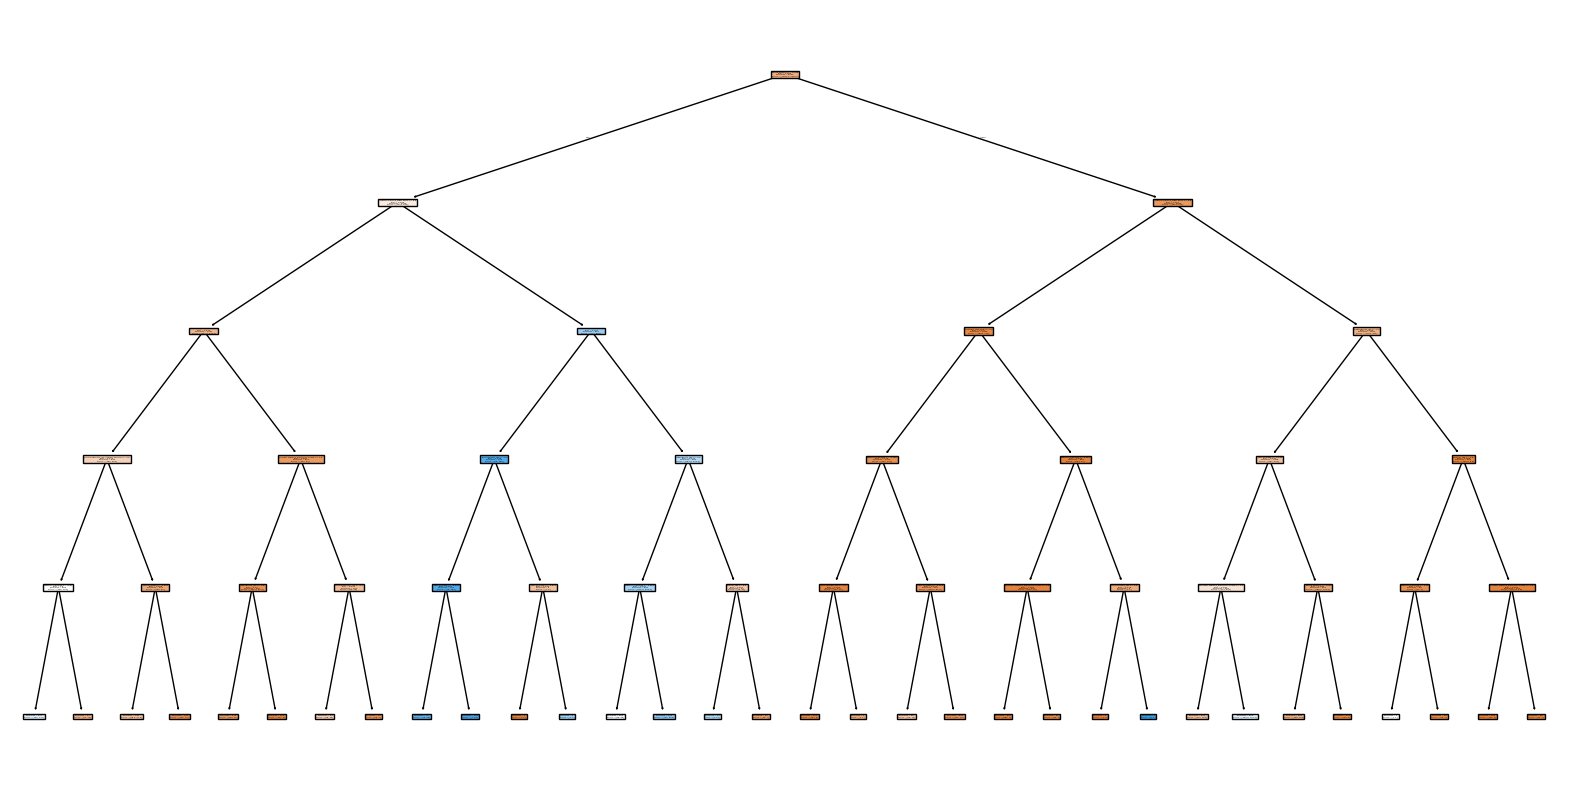

In [25]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(tree_model, feature_names=X_final.columns, filled=True)
plt.show()

In [26]:
import pandas as pd

importance = pd.Series(tree_model.feature_importances_, index=X_final.columns)
importance.sort_values(ascending=False).head(10)

,0
Tenure Months,0.382564
Internet Service_Fiber optic,0.319574
Total Charges,0.091056
Dependents_Yes,0.083922
Payment Method_Electronic check,0.031662
Monthly Charges,0.030648
Online Security_No internet service,0.029709
Contract_Two year,0.010344
Partner_Yes,0.008323
Tech Support_Yes,0.005667


## Model Comparison

We compare models using:
- Accuracy
- Precision
- Recall
- F1-score

This helps identify the best-performing model.

## Feature Importance Analysis

Using the Decision Tree, we analyze which features contribute most to churn prediction.

This provides valuable business insights.

## Business Insights

Key drivers of churn typically include:
- Contract type
- Monthly charges
- Tenure
- Internet and security services

These insights can be used by businesses to:
- Design retention campaigns
- Offer long-term contracts
- Improve customer experience

## Conclusion

This project demonstrates a full machine learning pipeline:
- Data cleaning
- Feature engineering
- Encoding
- Scaling
- Imputation
- Model training
- Evaluation
- Business interpretation

The final model can help organizations proactively reduce customer churn and improve long-term revenue.

In [27]:
import joblib

joblib.dump(tree_model, "model_v2.pkl")
joblib.dump(scaler, "scaler_v2.pkl")
joblib.dump(imputer, "imputer_v2.pkl")

['imputer_v2.pkl']

In [28]:
import os
os.listdir()

['.config',
 'imputer_v2.pkl',
 'Telco_customer_churn.xlsx',
 'scaler_v2.pkl',
 'model_v2.pkl',
 'sample_data']

In [29]:
from google.colab import files
files.download("model_v2.pkl")
files.download("scaler_v2.pkl")
files.download("imputer_v2.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
import sys, sklearn, numpy, pandas, joblib
print(sys.version)
print("sklearn:", sklearn.__version__)
print("numpy:", numpy.__version__)
print("pandas:", pandas.__version__)
print("joblib:", joblib.__version__)


3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
sklearn: 1.6.1
numpy: 2.0.2
pandas: 2.2.2
joblib: 1.5.3
